In [ ]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from scipy.spatial import cKDTree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel

# Etapa 1 : Obtener datos .kml de la ciudad de La Plata.

In [2]:
gdf = gpd.read_file("laplata_cascourbano.kml", driver="KML")
print(gdf.head())


       Name                                        Description  \
0  La Plata  descripción: <br>name: La Plata <br>descriptio...   
1  La Plata  descripción: <br>name: La Plata <br>descriptio...   
2  La Plata  descripción: <br>name: La Plata <br>descriptio...   
3  La Plata  descripción: <br>name: La Plata <br>descriptio...   
4  La Plata  descripción: <br>name: La Plata <br>descriptio...   

                                            geometry  
0  MULTIPOLYGON Z (((-57.93986 -34.92733 0, -57.9...  
1  MULTIPOLYGON Z (((-57.9475 -34.94511 0, -57.94...  
2  MULTIPOLYGON Z (((-57.93726 -34.93996 0, -57.9...  
3  MULTIPOLYGON Z (((-57.9535 -34.95246 0, -57.95...  
4  POLYGON Z ((-57.93649 -34.93926 0, -57.93649 -...  


/home/andy/.local/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'laplata_cascourbano.kml': 'La Plata' (default), 'La Plata (#2)', 'La Plata (#3)'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
# Chequear cuántas capas tiene el archivo kml
for layer in fiona.listlayers("laplata_cascourbano.kml"):
    print(layer)

La Plata
La Plata (#2)
La Plata (#3)


In [4]:
# Convertir el archivo kml a geojson
gdf.to_file("salida.geojson", driver='GeoJSON')

<AxesSubplot:>

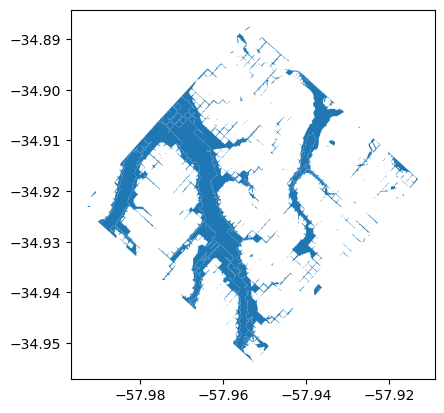

In [5]:
# Plotear el archivo geojson
gdf = gpd.read_file("salida.geojson")
gdf.plot()

# Etapa 2 : Obtener datos de densidad poblacional de la ciudad de La Plata.

In [6]:
# Dataset de densidad poblacional Argentina 2020 (1km resolución, ~4M puntos)
pd.read_csv("arg_pd_2020_1km_ASCII_XYZ.csv")

,X,Y,Z
0,-66.238750,-21.779583,6.852734
1,-66.230416,-21.779583,6.771198
2,-66.222083,-21.779583,3.273827
3,-66.213750,-21.779583,3.047135
4,-66.205416,-21.779583,3.772367
...,...,...,...
3988577,-66.447083,-55.054583,0.408210
3988578,-66.438750,-55.054583,0.400157
3988579,-66.430416,-55.054583,0.399001
3988580,-66.422083,-55.054583,0.395959


In [7]:
# Función para extraer datos de una ciudad específica del dataset completo
def extract_city_data(city_name: str, bounds: dict) -> pd.DataFrame:

    df = pd.read_csv("arg_pd_2020_1km_ASCII_XYZ.csv")
    
    city_data = df[
        (df['X'] >= bounds['x_min']) & 
        (df['X'] <= bounds['x_max']) & 
        (df['Y'] >= bounds['y_min']) & 
        (df['Y'] <= bounds['y_max'])
    ]
    
    # Guardar subset
    output_file = f"{city_name.lower().replace(' ', '_')}_population_2020.csv"
    city_data.to_csv(output_file, index=False)
    
    print("Filas extraídas:", f"{len(city_data):,}")
    
    return city_data

In [8]:
# Coordenadas aproximadas para La Plata
la_plata_bounds = {
   'x_min': -58.2,
   'x_max': -57.7,
   'y_min': -35.2,
   'y_max': -34.7
}

# Extraer datos
la_plata_data = extract_city_data("La Plata", la_plata_bounds)


Filas extraídas: 2,782


In [9]:
# Leer el archivo CSV de densidad de población de La Plata
df = pd.read_csv('la_plata_population_2020.csv')
    
# Crear geometría de puntos usando X,Y como longitud,latitud
geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]
    

In [10]:
# Crear GeoDataFrame
CRS_4326 = 4326
gdf_densidad= gpd.GeoDataFrame(df, geometry=geometry, crs=CRS_4326)
    
# Agregar columna de densidad con nombre descriptivo
gdf_densidad['densidad_poblacional_lp'] = gdf_densidad['Z']
gdf_densidad


,X,Y,Z,geometry,densidad_poblacional_lp
0,-58.197083,-34.729583,408.588806,POINT (-58.19708 -34.72958),408.588806
1,-58.197083,-34.737916,611.415833,POINT (-58.19708 -34.73792),611.415833
2,-58.188750,-34.737916,754.757263,POINT (-58.18875 -34.73792),754.757263
3,-58.180416,-34.737916,1786.521606,POINT (-58.18042 -34.73792),1786.521606
4,-58.197083,-34.746250,1726.598145,POINT (-58.19708 -34.74625),1726.598145
...,...,...,...,...,...
2777,-57.738750,-35.196250,2.869491,POINT (-57.73875 -35.19625),2.869491
2778,-57.730416,-35.196250,2.516356,POINT (-57.73042 -35.19625),2.516356
2779,-57.722083,-35.196250,2.450618,POINT (-57.72208 -35.19625),2.450618
2780,-57.713750,-35.196250,2.161114,POINT (-57.71375 -35.19625),2.161114


In [11]:
#gdf.to_crs() #cone esto cambio el sistema de referencia de coordenadas

In [12]:
def export_to_geojson(gdf_densidad: gpd.GeoDataFrame, output_path:str = "la_plata_densidad.geojson") -> str:
        """
    Exporta un GeoDataFrame a formato GeoJSON
    
    Args:
        gdf_densidad: GeoDataFrame con datos de densidad
        output_path: Ruta de salida (default: "la_plata_densidad.geojson")
    
    Returns:
        str: Ruta del archivo exportado
    """
        
        gdf_densidad.to_file(output_path, driver='GeoJSON')
        print(f"Archivo exportado: {output_path}")
        return output_path

In [13]:
export_to_geojson(gdf_densidad)

Archivo exportado: la_plata_densidad.geojson


'la_plata_densidad.geojson'

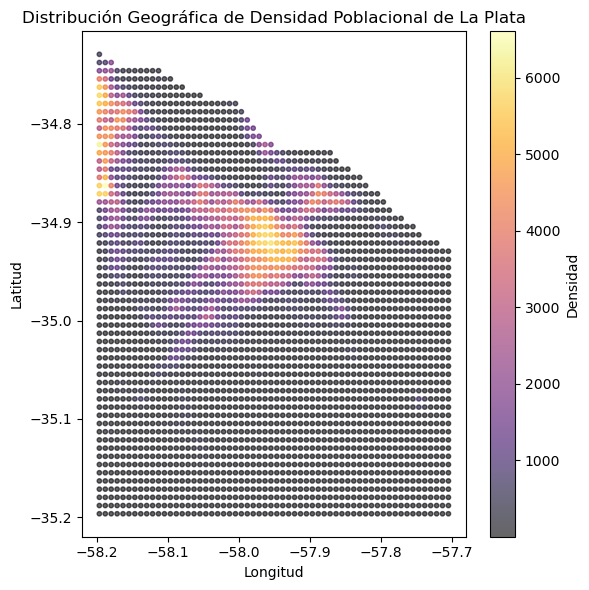

In [14]:
# Visualización de la densidad poblacional de La Plata
fig, axes = plt.subplots(figsize=(6, 6))

# Gráfico de dispersión geográfica
scatter = axes.scatter(
    gdf_densidad['X'], gdf_densidad['Y'], c=gdf_densidad['Z'],
    cmap='inferno', alpha=0.6, s=10
)
axes.set_xlabel('Longitud')
axes.set_ylabel('Latitud')
axes.set_title('Distribución Geográfica de Densidad Poblacional de La Plata')
plt.colorbar(scatter, ax=axes, label='Densidad')

plt.tight_layout()
plt.savefig('densidad_la_plata.png', dpi=300, bbox_inches='tight')
plt.show()

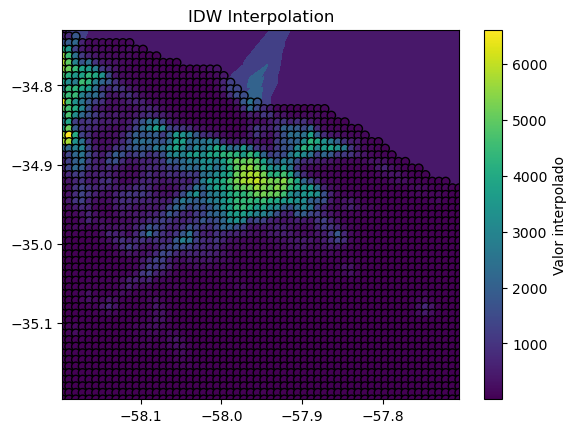

In [ ]:
# Visualización de la densidad poblacional de La Plata usando IDW (Inverse Distance Weighting)
# Leer puntos
gdf = gpd.read_file("la_plata_densidad.geojson") 

# Convertir a coordenadas x, y
coords = np.array([[point.x, point.y] for point in gdf.geometry]) # Itera sobre los puntos de geometría
values = gdf_densidad["Z"].values

# Crear grilla
grid_x, grid_y = np.mgrid[min(coords[:,0]):max(coords[:,0]):1000j,
                          min(coords[:,1]):max(coords[:,1]):1000j]
grid_coords = np.vstack([grid_x.ravel(), grid_y.ravel()]).T # Convierte la grilla 2d en una lista de pares de coordenadas

# IDW con cKDTree
tree = cKDTree(coords)
dists, idxs = tree.query(grid_coords, k=8)  # Por cada punto del grid, encuentra los 8 vecinos más cercanos

weights = 1 / (dists + 1e-12) #fórmula de IDW
weights /= weights.sum(axis=1)[:, None] # Normaliza los pesos para que sumen 1 en cada fila
grid_z = np.sum(weights * values[idxs], axis=1).reshape(grid_x.shape) #devuelve una sup. interpolada donde a cada valor se usa IDW

# Graficar
plt.contourf(grid_x, grid_y, grid_z, cmap="viridis")
plt.scatter(coords[:,0], coords[:,1], c=values, edgecolor='k')
plt.colorbar(label="Valor interpolado")
plt.title("IDW Interpolation")
plt.show()


In [ ]:
# Visualización de la densidad poblacional de La Plata usando Kriging

# Kriging usando Gaussian Process
kernel = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

In [ ]:
# Recortar el GeoDataFrame de densidad poblacional con el GeoDataFrame de La Plata

In [ ]:
def clip_density_to_urban_area(gdf_density: gpd.GeoDataFrame, gdf_geographical: gpd.GeoDataFrame) -> gpd.GeoDataFrame: 
    """
    Recorta los puntos de densidad que caen dentro del casco urbano de un límite geográfico dado.
    
    Args:
        gdf_density: GeoDataFrame con datos de densidad
        gdf_geographical: GeoDataFrame con límites geográficos

    Returns:
        gpd.GeoDataFrame: GeoDataFrame recortado a la zona urbana
    """
    # Usar spatial join para mantener solo puntos dentro del casco urbano
    points_in_casco = gpd.sjoin(gdf_density, gdf_geographical, how='inner', predicate='intersects')
    
    # Limpiar columnas duplicadas del join 
    points_in_casco = points_in_casco.drop(columns=[col for col in points_in_casco.columns if col.endswith('_right')]) 
    
    return points_in_casco

In [ ]:
casco_urbano = clip_density_to_urban_area(gdf_densidad, gdf)

In [ ]:
casco_urbano

In [ ]:
## Visualización simple 
#fig, ax = plt.subplots(figsize=(12, 10))
#
## Plotear el límite del casco urbano
#gdf.boundary.plot(ax=ax, color='red', linewidth=2, alpha=0.8)
#
## Plotear los puntos de densidad
#scatter = ax.scatter(casco_urbano['X'], casco_urbano['Y'], 
#                    c=casco_urbano['Z'], 
#                    cmap='viridis', 
#                    s=30, 
#                    alpha=0.7)
#
#plt.colorbar(scatter, label='Densidad Poblacional')
#ax.set_title('Casco Urbano - La Plata')
#ax.set_aspect('equal')
#plt.show()

# Etapa 3 : superposición de mapas de densidad y peligrosidad de inundación de la ciudad de La Plata (QGIS).

In [ ]:
# Verificaión de los sistemas de referencia espacial
gdf_mapa = gpd.read_file("salida.geojson")
print(gdf.crs)
print(gdf_mapa.crs)